In [1]:
#     This program is free software: you can redistribute it and/or modify
#     it under the terms of the GNU General Public License as published by
#     the Free Software Foundation, either version 3 of the License, or
#     (at your option) any later version.
#
#     This program is distributed in the hope that it will be useful,
#     but WITHOUT ANY WARRANTY; without even the implied warranty of
#     MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#     GNU General Public License for more details.
#
#     You should have received a copy of the GNU General Public License
#     along with this program.  If not, see <https://www.gnu.org/licenses/>.

#     Written by Charalambos (Charis) Poullis - www.poullis.org

In [2]:
#import the necessary modules
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [3]:
#Set the path for the datasets
DATASET_PATH = "../data"

#Download the dataset: CIFAR10
training_dataset = torchvision.datasets.CIFAR10(root=DATASET_PATH,
                                                train=True,
                                                download=True,
                                                transform=torchvision.transforms.ToTensor())
print('Training dataset:', training_dataset)
testing_dataset = torchvision.datasets.CIFAR10(root=DATASET_PATH,
                                               train=False,
                                               download=True,
                                               transform=torchvision.transforms.ToTensor())
print('Testing dataset:', testing_dataset)  
labels=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

Files already downloaded and verified
Training dataset: Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: ToTensor()
Files already downloaded and verified
Testing dataset: Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [4]:
#This function takes a CIFAR dataset and splits it into two numpy arrays containing
#the images and labels, respectively

def splitDataset(dataset):
    #Divide the datasets into images and labels
    x, y = dataset[0]
    
    shape = [(i, *j) for i, j in [(len(dataset), x.shape)]][0]
    images = np.zeros(shape)
    labels = np.zeros((len(dataset), 1))
    
    for i in range(len(dataset)):
        x,y = dataset[i]
        images[i] = x
        labels[i] = y
        
    images = np.reshape(images, (len(dataset),-1))
    labels = np.reshape(labels, (len(dataset),-1))
    return images, labels

In [5]:
#Divide the training datasets into images and labels
training_images, training_labels = splitDataset(training_dataset)
#Do the same for the testing dataset
testing_images, testing_labels = splitDataset(testing_dataset)   

print(f'Training images: {len(training_images)}, Training labels: {len(training_labels)}')
print(f'Testing images: {len(testing_images)}, Testing labels: {len(testing_labels)}')
print(training_images.shape, training_labels.shape)
print(testing_images.shape, testing_labels.shape)

Training images: 50000, Training labels: 50000
Testing images: 10000, Testing labels: 10000
(50000, 3072) (50000, 1)
(10000, 3072) (10000, 1)


In [6]:
class MyNN:
    def __init__(self):
        self.X_train = None
        self.Y_train = None
        return

    def train(self, X_train, Y_train):
        self.X_train = X_train
        self.Y_train = Y_train
        return

    def test(self, X_test, Y_test_gt, number_of_NNs):
        correct_predictions = 0
        
        #Allocate the right size
        Y_test = np.zeros((Y_test_gt.shape[0], number_of_NNs))
        Y_test_NN_indices = np.zeros((Y_test_gt.shape[0], number_of_NNs))

        for i in range(0, len(X_test)):
            #We define the similarity as the sum of the absolute differences
            similarities = np.sum(np.abs(X_test[i,:] - self.X_train), axis=1)
            #Get number_of_NNs smallest similarities
            nearest_neighbours_indices = np.argsort(similarities)[:number_of_NNs]        
            #Copy the indices
            Y_test_NN_indices[i] = nearest_neighbours_indices
            #Copy the labels from the nearest neighbours
            Y_test[i] = self.Y_train[nearest_neighbours_indices].reshape(-1)
                   
            #calculate how many are correct; take the majority vote of labels from nearest neighbours
            c = Counter(Y_test[i].tolist())
            predicted_label, votes = c.most_common()[0]
            if predicted_label == Y_test_gt[i]:
                correct_predictions += 1
                
        return correct_predictions, Y_test, Y_test_NN_indices

In [7]:
#Create an instance of the model
model = MyNN()

#Train the model using the training images and labels
model.train(training_images, training_labels)
print("Training complete")

#Predict the labels for the test images
how_many_to_process = 5
number_of_NNs = 5
correct_predictions, predicted_labels, nearest_neighbours_indices = model.test(testing_images[:how_many_to_process], testing_labels[:how_many_to_process], number_of_NNs)
print(f"Accuracy: {correct_predictions} out of {how_many_to_process}")

Training complete
Accuracy: 3 out of 5


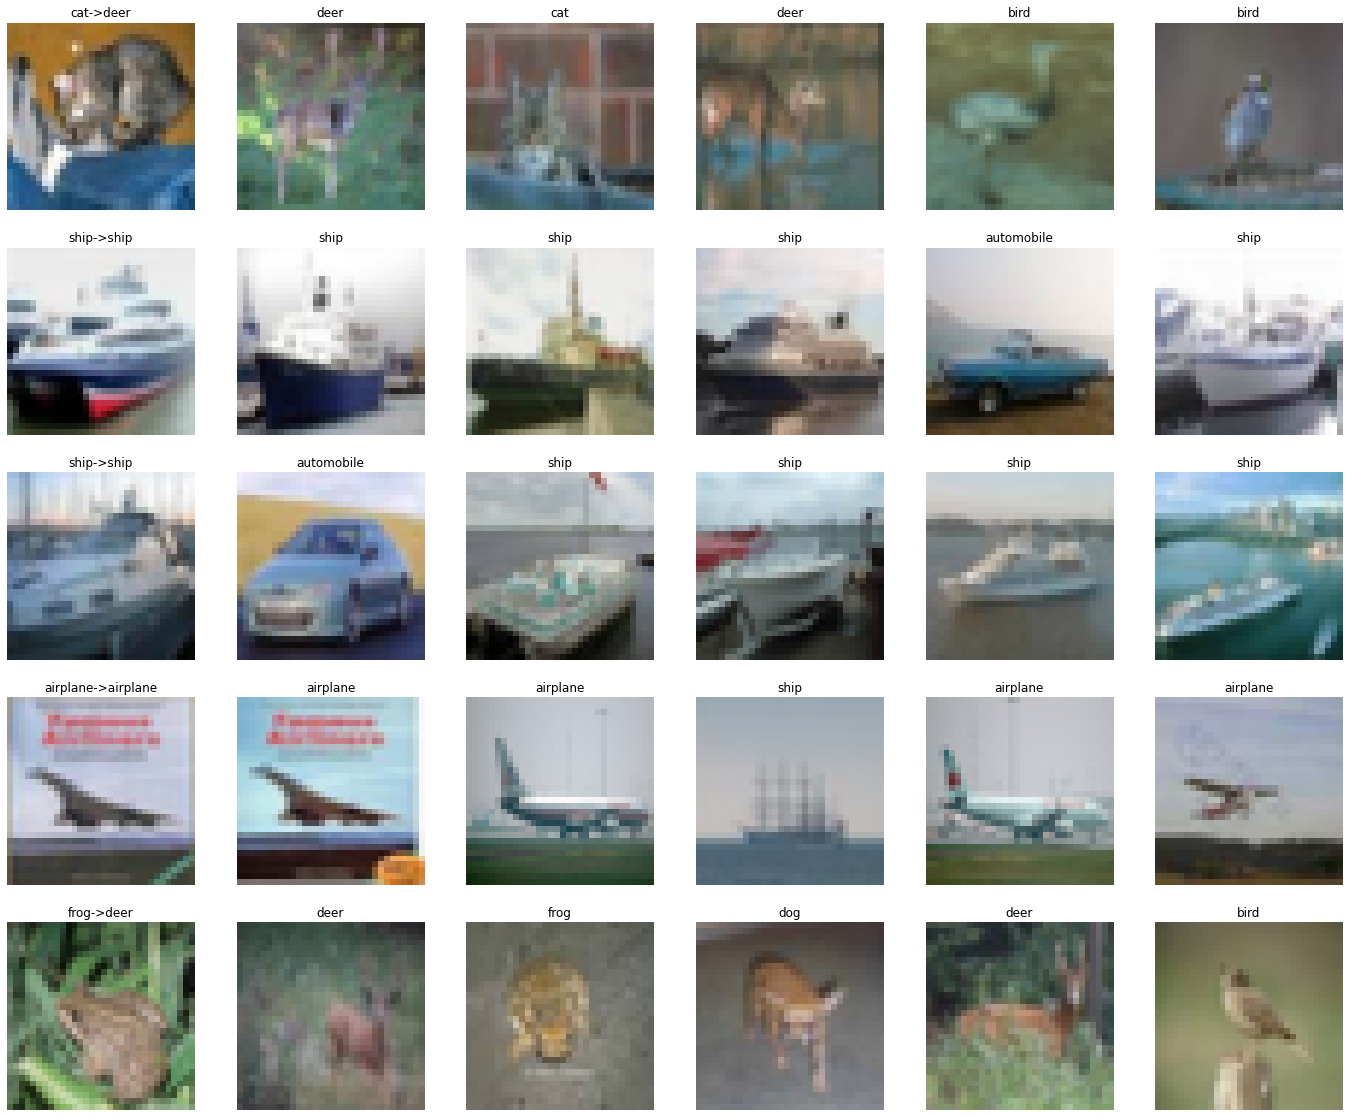

In [8]:
cols, rows = 1+number_of_NNs, how_many_to_process
figure = plt.figure(figsize=(4*cols, 4*rows))

image_counter = 1
for i in range(0, how_many_to_process):
    figure.add_subplot(rows, cols, image_counter)
    image_counter+=1
    plt.axis("off")
    img = testing_images[i]
    nearest_neighbours_labels = [int(nn) for nn in predicted_labels[i]]
    c = Counter(nearest_neighbours_labels)
    predicted_label, votes = c.most_common()[0]
    plt.title(labels[int(testing_labels[i])]+"->"+labels[predicted_label])
    plt.imshow(img.reshape((3, 32, 32)).transpose(1,2,0))
    
    for j in range(0, number_of_NNs):
        figure.add_subplot(rows, cols, image_counter)
        image_counter+=1
        plt.axis("off")
        nearest_neighbour_index = int(nearest_neighbours_indices[i][j])
        img = training_images[nearest_neighbour_index]
        plt.title(labels[int(training_labels[nearest_neighbour_index])])
        plt.imshow(img.reshape((3, 32, 32)).transpose(1,2,0))
plt.show()
figure.savefig("nearest_neighbour.png", bbox_inches='tight', pad_inches = 0)